# University of Aberdeen

## Introduction to Machine Learning and Data-Mining (CS4049)

### Tutorial - Reinforcement Learning with OpenAI Gym

---

The practical is inspired from the code on: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in creating and training an agent to play an Atari game using the screen frames as input

### In this tutorial, we will use the following libraries and modules

In [2]:
# For deep neural networks
import tensorflow.compat.v1 as tf

# For data representation
import numpy as np
import random

# For handling files
import os

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt

# OpenAI Gym
import gym
env = gym.make("Boxing-v0")
# I have installed pyglet-1.5.11 for it work with BigSur

## Atari Games

In this tutorial, we will create an agent to play the Boxing Atari game. In this game, two boxers, one white and one black, compete against each other. When close enough, a boxer can hit his opponent with a punch which causes his opponent to reel back slightly. A match is completed either when one player lands 100 punches or two minutes have elapsed. In the case of a decision, the player with the most landed punches is the winner. Ties are possible. 

![Activision's Boxing Cartridge](Boxing.png)

In this tutorial, we will use the pixels as inputs. The OpenAI Gym environment is `Boxing-v0`. 

### Naive Agent
1.1. For the boxing game, describe the observations, the action space, the reward, the environment’s info dictionary and the episode.


In [3]:
print("Action space: ",env.action_space)
print("Observation space:", env.observation_space)

env.reset()
next_obs, reward, done, info = env.step(0)
print(info)


Action space:  Discrete(18)
Observation space: Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 2

The observation space is an RGB picture of size 210x160 and the action space is composed of the 18 actions that can be performed from an ATARI controller. The info dictionary contains the parameter `ale.lives` which is the number of remaining lives.

1.2. Create a simple agent that performs random actions.

In [4]:
class RandomAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self, observation):
        return random.choice(range(self.action_size))
    
reward_episodes = []
numberOfEpisodes = 10
agent = RandomAgent(env)
for ep in range(numberOfEpisodes):
    current_obs = env.reset()
    done = False
    total_reward_ep = 0
    while not done:
        action = agent.get_action(current_obs)
        next_obs, reward, done, info = env.step(action)
        env.render()
        total_reward_ep += reward
    reward_episodes.append(total_reward_ep)
        
print("Average reward per episode: {}".format(np.sum(reward_episodes)/numberOfEpisodes))
env.close()

C:\Users\Oliwe\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\atari\environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
C:\Users\Oliwe\AppData\Local\Programs\Python\Python39\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Average reward per episode: -0.4


### Deep Q-Learning Agent

1.3. Implement a pre-processing function to convert the $210\times160$ RGB frames to $96\times80$ greyscale frames. Then, change the type of the matrix to `int8`.


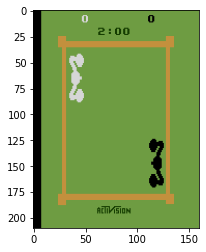

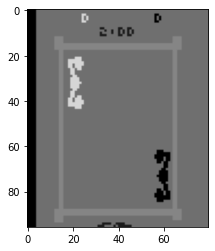

In [5]:
obs = env.reset()

def preprocess_observation(observation):
    img = observation[1:192:2, ::2]
    img = img.mean(axis=2) #The values or between 0 and 255
    img = (img - 128).astype(np.int8) #normalized the values between -128 and 127
    return img.reshape(96,80,1)
    

plt.imshow(obs)
plt.show()
plt.imshow(preprocess_observation(obs).reshape(96,80), cmap="gray", vmin=-128, vmax = 127)
plt.show()

1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [6]:
def q_network(X_state, name):
    prev_layer = X_state / 128 #the values will be between [-1, 1]
    initializer = tf.variance_scaling_initializer()
    hidden_activation = tf.nn.relu
    with tf.variable_scope(name) as scope:
        prev_layer = tf.layers.conv2d(prev_layer, filters=32,
                                     kernel_size = 8, strides = 4,
                                     padding="SAME", activation= hidden_activation,
                                     kernel_initializer = initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                     kernel_size = 4, strides = 2,
                                     padding="SAME", activation= hidden_activation,
                                     kernel_initializer = initializer)
        prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                     kernel_size = 3, strides = 1,
                                     padding="SAME", activation= hidden_activation,
                                     kernel_initializer = initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape= [-1, 64 * 12*10])
        hidden = tf.layers.dense(last_conv_layer_flat, 512,
                                activation = hidden_activation, kernel_initializer = initializer)
        outputs = tf.layers.dense(hidden, env.action_space.n, kernel_initializer = initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = scope.name)
    trainable_vars_by_name = { var.name[len(scope.name):] : var for var in trainable_vars}
    return outputs, trainable_vars_by_name






1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

In [7]:
class QLearningAgent():
    def __init__(self, env, learning_rate = 0.001, momemtum = 0.95):
        self.action_size = env.action_space.n
        self.loss_val = np.infty
        tf.reset_default_graph()
        tf.disable_eager_execution()
        
        self.discount_rate = 0.99
        
        self.checkpoint_path = "./my_dqn_boxing.ckpt"
        
        self.X_state = tf.placeholder(tf.float32, shape= [None, 96, 80, 1])
        self.online_q_values, self.online_vars = q_network(self.X_state, name = "q_networks/online")
        self.target_q_values, self.target_vars = q_network(self.X_state, name = "q_networks/target")
        
        #Define the operations to copy the online network to the target network
        self.copy_ops = [ target_var.assign(self.online_vars[var_name]) 
                         for var_name, target_var in self.target_vars.items()]
        self.copy_online_to_target = tf.group(*self.copy_ops)
        
        # The structure of the training
        with tf.variable_scope("train"):
            self.X_action = tf.placeholder(tf.int32, shape=[None])
            self.y = tf.placeholder(tf.float32, shape=[None, 1])
            self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),
                                         axis=1, keepdims = True)
            
            self.error = tf.abs( self.y - self.q_value) #A value between 0 and infty
            self.clipped_error = tf.clip_by_value(self.error, 0.0, 1.0) #If it is above 1 then it becomes 1
            self.linear_error = 2 * (self.error - self.clipped_error) 
            self.loss = tf.reduce_mean(tf.square(self.clipped_error) + self.linear_error)
            
            self.global_step = tf.Variable(0, trainable = False, name = "global_step")
            self.optimizer = tf.train.MomentumOptimizer(learning_rate, momentum = momemtum, use_nesterov = True)
            self.training_op = self.optimizer.minimize(self.loss, global_step = self.global_step)
            
        # Saving 
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        if os.path.isfile(self.checkpoint_path + ".index"):
            self.saver.restore(self.sess, self.checkpoint_path)
        else:
            self.sess.run(tf.global_variables_initializer())
            self.sess.run(self.copy_online_to_target)
            
    def get_action(self, q_values, step):
        epsilon = max(0.1, 1 - (0.9/2000000) * step)
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size)
        else:
            return np.argmax(q_values)
        
    
    
    def train(self, state_val, action_val, reward, next_state_val, continues):
        next_q_values = self.target_q_values.eval(feed_dict={self.X_state : np.array([next_state_val])})
        max_next_q_values = np.max(next_q_values , axis = 1, keepdims= True)
        #We can now compute the target value
        y_val = reward + continues * self.discount_rate *max_next_q_values
        _ , self.loss_val = self.sess.run([self.training_op, self.loss], 
                                         feed_dict= {self.X_state: np.array([state_val]),
                                                     self.X_action: np.array([action_val]),
                                                     self.y : y_val})

1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [ ]:
agent = QLearningAgent(env)


n_steps = 1000000
copy_steps = 5000
save_steps = 1000

with agent.sess:
    while True:
        step = agent.global_step.eval()
        if step >= n_steps:
            break
            
            
        print("\r\t Training step {}/{} ({:.1f})% \t Loss{:5f}".format(step,n_steps,step*100/ n_steps,agent.loss_val), end="")
        
        if done:
            obs = env.reset()
            state = preprocess_observation(obs)
            
        q_values = agent.online_q_values.eval(feed_dict={
            agent.X_state : [state]})
        action = agent.get_action(q_values,step)
        
        #We play the action from the agent
        next_obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(next_obs)
        agent.train(state, action, reward, next_state, 1.0 - done)
        
        env.render()
        
        state = next_state
        
        if step % copy_steps ==0:
            agent.copy_online_to_target.run()
        
        if step % save_steps ==0:
            agent.saver.save(agent.sess, agent.checkpoint_path)

Error: Session cannot generate requests

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.




1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?